In [21]:
!pip install tensorflow_federated

In [22]:
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import time
import math
import os

In [23]:
def create_dataset(data):
    #extracting features
    features = data.loc[:, ~data.columns.isin(["pm2.5", "pm10"])]
    #extracting labels
    targets = data.loc[:, data.columns.isin(["pm2.5", "pm10"])]
    #creating a timeseries datase
    return tf.keras.utils.timeseries_dataset_from_array(
        features.to_numpy(),
        targets.to_numpy(),
        #interval period, we have data at every 1 hour intervals
        sequence_length=1,
        #taking all rows into one
        batch_size=1,
        sequence_stride=1,
        shuffle=False
    )

In [24]:
#ref - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/
class Attention(keras.layers.Layer):
    def __init__(self,**kwargs):
        super(Attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.relu(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [25]:
def create_fl_clients(data, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        client_batch_data = data[idx_from:idx_to]
        #creates a interval timeseries dataset
        dataset = create_dataset(client_batch_data)
        datasets.append(dataset)
        
    return datasets

In [26]:
def model_fn():
    #declaring our input shape for model
    input_spec = collections.OrderedDict(
        #feature size
        x=tf.TensorSpec(shape=(None, None, input_size), dtype=tf.float64, name=None),
        #label size
        y=tf.TensorSpec(shape=(None, 2), dtype=tf.float64, name=None)
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Input(shape=(1, input_size)),
            tf.keras.layers.Conv1D(
                filters=50,
                kernel_size=5,
                strides=1,
                padding="causal",
              activation="relu"
            ),
            tf.keras.layers.LSTM(30, return_sequences=True),
            tf.keras.layers.LSTM(30, return_sequences=True),
            Attention(),
            tf.keras.layers.Dense(50, activation="relu"),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(2),
        ]
    )
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [27]:
def train(trainer, train_data, val_data, test_data, num_rounds, no_of_clients):
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #creating FL clients
    datasets = create_fl_clients(train_data, no_of_clients)
    #TODO: Randomly slecting clients

    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    #create timeseries datasets for validation and testing
    eval_client_data = create_dataset(val_data)
    test_client_data = create_dataset(test_data)

    #for plotting we declare arrays
    train_acc = []
    train_loss = []
    eval_acc = []
    eval_loss = []
    test_acc = []
    test_loss = []
    for n in range(num_rounds):
        #passing the new state with training dataset
        result = trainer.next(state, datasets)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']

        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [eval_client_data])
        eval_metrics = eval_metrics['eval']

        #using learning algorithm we pass the currrent state of round for testing
        test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        test_metrics = test_metrics['eval']

        print('Round:{a} Train - RMSE:{m:.2f}, Loss:{t:.2f} | Eval - RMSE:{b:.2f}, Loss:{c:.2f} | Test - RMSE:{d:.2f}, Loss:{e:.2f}'.format(
              a=n,
              m=train_metrics['root_mean_squared_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              c=eval_metrics['loss'],
              d=test_metrics['root_mean_squared_error'],
              e=test_metrics['loss']
        ))

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_loss.append(eval_metrics['loss'])

        test_acc.append(test_metrics['root_mean_squared_error'])
        test_loss.append(test_metrics['loss'])

    return train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss

In [28]:
def plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss):
  plt.plot(train_acc, label="Training")
  plt.plot(eval_acc, label="Evaluation")
  plt.plot(test_acc, label="Testing")
  plt.title("RMSE")
  plt.xlabel("Rounds")
  plt.legend()
  plt.show()

  plt.plot(train_loss, label="Training")
  plt.plot(eval_loss, label="Evaluation")
  plt.plot(test_loss, label="Testing")
  plt.title("Loss")
  plt.xlabel("Rounds")
  plt.legend()
  plt.show()

In [29]:
def main(data, server_optimizer_fn, client_optimizer_fn, NUM_CLIENTS, ROUNDS, SERVER_LR, CLIENT_LR):
    #lengths for train test and validation sets 70-15-15
    total_samples = len(data)
    train_samples = int(0.7 * total_samples)
    val_samples = int(0.15 * total_samples)

    #subsetting the original data as per set lengths
    train_data = data[:train_samples]
    val_data = data[train_samples:train_samples + val_samples]
    test_data = data[train_samples + val_samples:]

    trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

    train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = train(
        trainer,
        train_data,
        val_data,
        test_data,
        num_rounds=ROUNDS,
        no_of_clients=NUM_CLIENTS
    )

    return train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss

<ipython-input-27-2f409b77b3f4>:4: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:6.28, Loss:39.42 | Eval - RMSE:13.06, Loss:170.63 | Test - RMSE:12.08, Loss:145.84
Round:1 Train - RMSE:6.23, Loss:38.87 | Eval - RMSE:11.17, Loss:124.78 | Test - RMSE:10.20, Loss:104.11
Round:2 Train - RMSE:6.12, Loss:37.50 | Eval - RMSE:8.94, Loss:79.86 | Test - RMSE:8.03, Loss:64.53
Round:3 Train - RMSE:6.02, Loss:36.19 | Eval - RMSE:7.04, Loss:49.54 | Test - RMSE:6.33, Loss:40.12
Round:4 Train - RMSE:5.95, Loss:35.36 | Eval - RMSE:6.30, Loss:39.68 | Test - RMSE:6.01, Loss:36.10
Round:5 Train - RMSE:5.93, Loss:35.18 | Eval - RMSE:6.91, Loss:47.69 | Test - RMSE:7.02, Loss:49.30
Round:6 Train - RMSE:5.96, Loss:35.56 | Eval - RMSE:8.07, Loss:65.12 | Test - RMSE:8.41, Loss:70.81
Round:7 Train - RMSE:6.02, Loss:36.21 | Eval - RMSE:9.05, Loss:81.91 | Test - RMSE:9.50, Loss:90.28


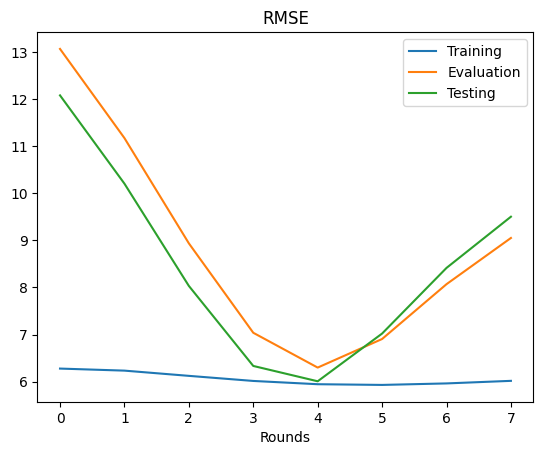

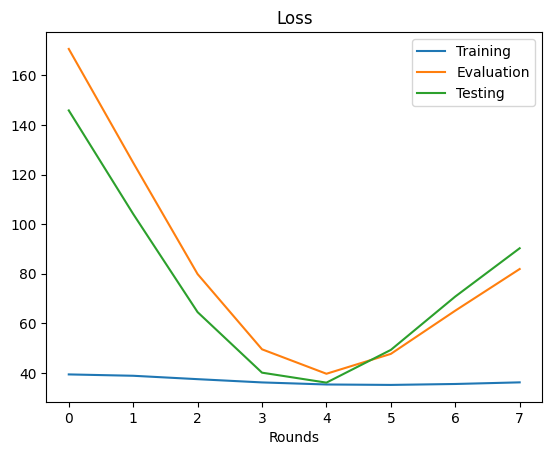

In [30]:
#setting number of clients
NUM_CLIENTS = 20
ROUNDS = 8
SERVER_LR = 0.01
CLIENT_LR = 0.1

server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

data = pd.read_csv('/Users/adityapimpalkar/Documents/AQI_new/AQI_federated_learning/data/dublin_port/dublin_port.csv')
#dropping uncessary columns
data = data.drop(['datetime' ,'Unnamed: 0'], axis=1)

features = data.loc[:,~data.columns.isin(["pm2.5", "pm10"])]
label = data.loc[:,data.columns.isin(["pm2.5", "pm10"])]

#normalizing data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

norm_df = pd.DataFrame(normalized_data, columns=features.columns)

#combining normalized feature data with label columns
data = pd.concat([norm_df, label], axis=1)

#setting input size for model
input_size = len(features.columns)

train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss)

<ipython-input-27-2f409b77b3f4>:4: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:7.62, Loss:58.08 | Eval - RMSE:13.25, Loss:175.51 | Test - RMSE:12.26, Loss:150.31
Round:1 Train - RMSE:7.00, Loss:49.00 | Eval - RMSE:11.88, Loss:141.09 | Test - RMSE:10.90, Loss:118.76
Round:2 Train - RMSE:6.70, Loss:44.87 | Eval - RMSE:10.21, Loss:104.33 | Test - RMSE:9.26, Loss:85.72
Round:3 Train - RMSE:6.36, Loss:40.40 | Eval - RMSE:8.51, Loss:72.46 | Test - RMSE:7.62, Loss:58.13
Round:4 Train - RMSE:6.05, Loss:36.66 | Eval - RMSE:7.14, Loss:50.98 | Test - RMSE:6.41, Loss:41.07
Round:5 Train - RMSE:5.92, Loss:35.05 | Eval - RMSE:6.41, Loss:41.03 | Test - RMSE:5.94, Loss:35.24
Round:6 Train - RMSE:5.81, Loss:33.74 | Eval - RMSE:6.34, Loss:40.21 | Test - RMSE:6.16, Loss:37.93
Round:7 Train - RMSE:5.82, Loss:33.85 | Eval - RMSE:6.67, Loss:44.49 | Test - RMSE:6.70, Loss:44.92


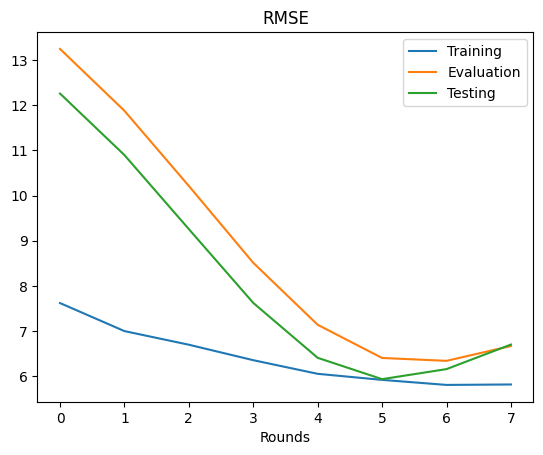

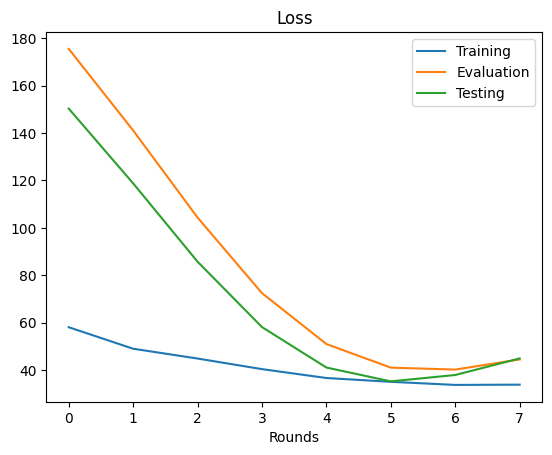

In [32]:
#setting number of clients
NUM_CLIENTS = 20
ROUNDS = 8
SERVER_LR = 0.001
CLIENT_LR = 0.1

server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

data = pd.read_csv('/Users/adityapimpalkar/Documents/AQI_new/AQI_federated_learning/data/dublin_port/dublin_port.csv')
#dropping uncessary columns
data = data.drop(['datetime' ,'Unnamed: 0'], axis=1)

features = data.loc[:,~data.columns.isin(["pm2.5", "pm10"])]
label = data.loc[:,data.columns.isin(["pm2.5", "pm10"])]

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

norm_df = pd.DataFrame(normalized_data, columns=features.columns)

data = pd.concat([norm_df, label], axis=1)

input_size = len(features.columns)

train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss)

<ipython-input-27-2f409b77b3f4>:4: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:8.04, Loss:64.59 | Eval - RMSE:13.77, Loss:189.48 | Test - RMSE:12.78, Loss:163.26
Round:1 Train - RMSE:7.37, Loss:54.25 | Eval - RMSE:12.83, Loss:164.58 | Test - RMSE:11.85, Loss:140.41
Round:2 Train - RMSE:6.79, Loss:46.09 | Eval - RMSE:11.12, Loss:123.64 | Test - RMSE:10.16, Loss:103.25
Round:3 Train - RMSE:6.32, Loss:39.89 | Eval - RMSE:8.65, Loss:74.75 | Test - RMSE:7.77, Loss:60.34
Round:4 Train - RMSE:6.03, Loss:36.39 | Eval - RMSE:6.47, Loss:41.86 | Test - RMSE:5.96, Loss:35.55
Round:5 Train - RMSE:5.92, Loss:35.03 | Eval - RMSE:7.28, Loss:53.06 | Test - RMSE:7.49, Loss:56.04
Round:6 Train - RMSE:5.94, Loss:35.29 | Eval - RMSE:10.57, Loss:111.79 | Test - RMSE:11.11, Loss:123.46
Round:7 Train - RMSE:6.04, Loss:36.47 | Eval - RMSE:13.48, Loss:181.69 | Test - RMSE:14.12, Loss:199.48


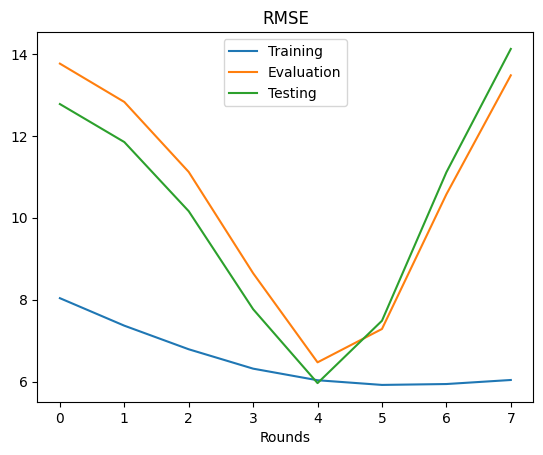

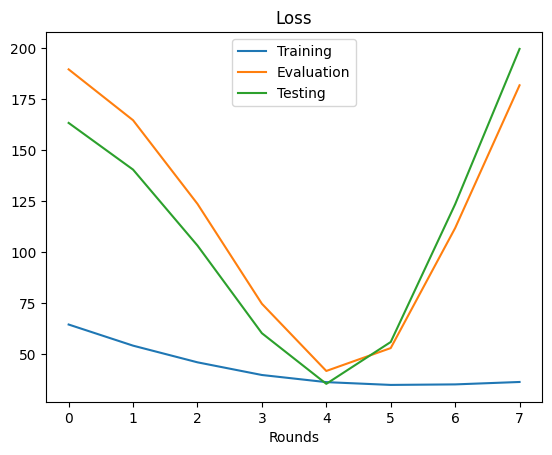

In [33]:
#setting number of clients
NUM_CLIENTS = 20
ROUNDS = 8
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

data = pd.read_csv('dublin_port.csv')
#dropping uncessary columns
data = data.drop(['datetime' ,'Unnamed: 0'], axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

norm_df = pd.DataFrame(normalized_data, columns=features.columns)

data = pd.concat([norm_df, label], axis=1)

input_size = len(features.columns)

train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss)

<ipython-input-27-2f409b77b3f4>:4: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Round:0 Train - RMSE:11.75, Loss:138.15 | Eval - RMSE:14.10, Loss:198.89 | Test - RMSE:13.11, Loss:171.99
Round:1 Train - RMSE:9.19, Loss:84.47 | Eval - RMSE:14.00, Loss:195.88 | Test - RMSE:13.01, Loss:169.30
Round:2 Train - RMSE:8.55, Loss:73.09 | Eval - RMSE:13.77, Loss:189.53 | Test - RMSE:12.78, Loss:163.43
Round:3 Train - RMSE:7.61, Loss:57.90 | Eval - RMSE:12.96, Loss:167.89 | Test - RMSE:11.93, Loss:142.36
Round:4 Train - RMSE:6.52, Loss:42.48 | Eval - RMSE:9.64, Loss:92.86 | Test - RMSE:8.51, Loss:72.44
Round:5 Train - RMSE:5.61, Loss:31.48 | Eval - RMSE:6.39, Loss:40.79 | Test - RMSE:6.33, Loss:40.11
Round:6 Train - RMSE:5.40, Loss:29.16 | Eval - RMSE:14.47, Loss:209.30 | Test - RMSE:15.57, Loss:242.44
Round:7 Train - RMSE:6.30, Loss:39.74 | Eval - RMSE:25.26, Loss:637.86 | Test - RMSE:26.78, Loss:717.03


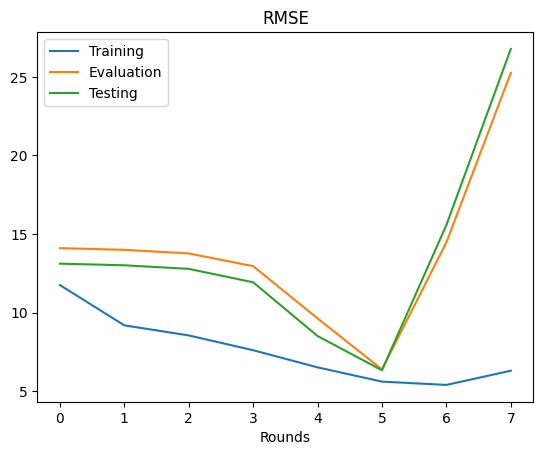

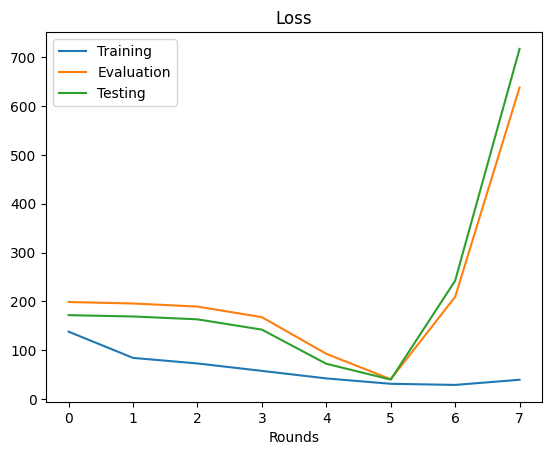

In [34]:
#setting number of clients
NUM_CLIENTS = 20
ROUNDS = 8
#SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn=lambda: tf.keras.optimizers.Adam()
client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

data = pd.read_csv('/Users/adityapimpalkar/Documents/AQI_new/AQI_federated_learning/data/dublin_port/dublin_port.csv')
#dropping uncessary columns
data = data.drop(['datetime' ,'Unnamed: 0'], axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

norm_df = pd.DataFrame(normalized_data, columns=features.columns)

data = pd.concat([norm_df, label], axis=1)

input_size = len(features.columns)

train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss = main(data,
                                                                       server_optimizer_fn,
                                                                       client_optimizer_fn,
                                                                       NUM_CLIENTS,
                                                                       ROUNDS,
                                                                       SERVER_LR,
                                                                       CLIENT_LR)

plot(train_acc, train_loss, eval_acc, eval_loss, test_acc, test_loss)